In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import geopandas as gpd
import itertools
import time
import random
import ast

In [2]:
# Utils & Functions
from utils import *
from hrga import *
from tndp import *
from export import *
from plot import *

### Graph Structure for Instance 4 (Administrative Regions for Rio de Janeiro Road Network)

The fourth instance is generated from Rio de Janeiro's Road Network.

In [3]:
# Download Rio de Janeiro Road Network from OSM database using osmnx (Boeing, 2017)
G = ox.graph_from_place('Rio de Janeiro, RJ', network_type='drive', simplify=True)

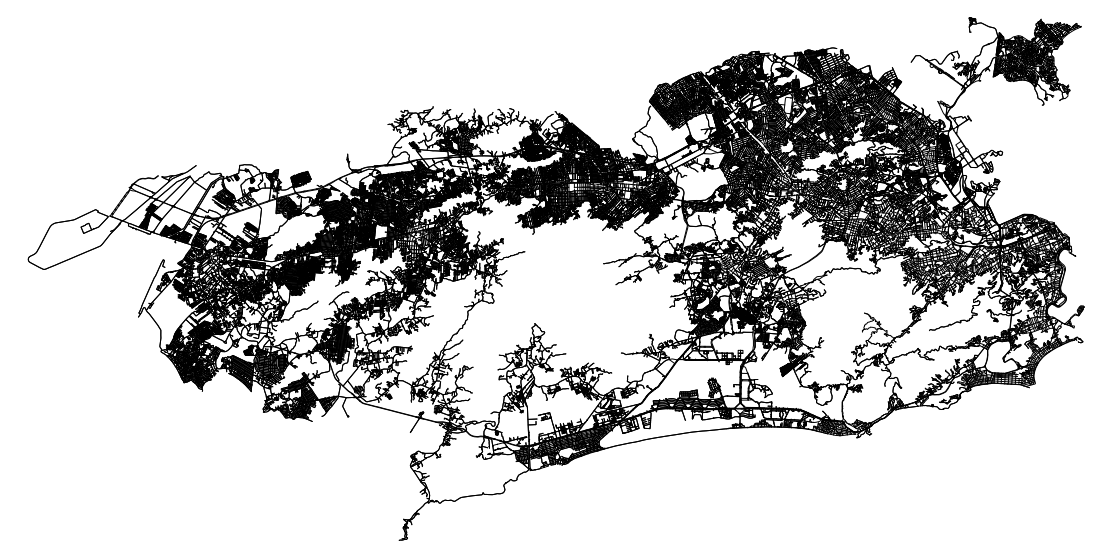

(<Figure size 1440x720 with 1 Axes>, <AxesSubplot:>)

In [4]:
# Plot figure
ox.plot_graph(G, figsize=(20, 10), bgcolor='#ffffff', node_color='#000000', edge_color='#000000', node_size=1)

In [5]:
# Some status of the graph
print(f'Graph Size - Nodes: {len(G.nodes())} | Edges: {len(G.edges())}')
print(f'Estimated size for simplified graph - Nodes: {33} | Edges: {(33*32)}')

Graph Size - Nodes: 70936 | Edges: 171896
Estimated size for simplified graph - Nodes: 33 | Edges: 1056


In [6]:
# Read Geometry for Administrative Regions of Rio de Janeiro
neighborhoods = gpd.read_file('data/Limite_de_bairros.shp')

# Dissolve into Administrative Regions
administrative_regions = neighborhoods.dissolve(by='REGIAO_ADM', aggfunc='sum').reset_index()

# Remove unwanted columns
administrative_regions = (
    administrative_regions
    [['REGIAO_ADM', 'CODRA', 'geometry']]
    .rename(
        columns={
            'REGIAO_ADM' : 'adm_region',
            'CODRA' : 'adm_region_id'
        }
    )
    .assign(
        centroid_x = administrative_regions.geometry.centroid.x,
        centroid_y = administrative_regions.geometry.centroid.y
    )
)

C:\Users\Thales Mesentier\Anaconda3\envs\uia2021\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

C:\Users\Thales Mesentier\Anaconda3\envs\uia2021\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [7]:
# Manually set Centroids for região Portuaria
administrative_regions.at[22, 'centroid_x'] = -43.199050
administrative_regions.at[22, 'centroid_y'] = -22.897430

In [8]:
# Remove Paquetá from list (since it is not connected to the road network)
administrative_regions = (
    administrative_regions
    .drop(19)
    .reset_index()
    .drop(['index'], axis=1)
)

#### Find Neighbors in Geometry and Calculate Shortest Path for Neighbors Only

This method uses the geometry to define edges. If exists a border between two administrative regions, then they are connected through an edge. Then, shortest paths are calculated for each edge.

In [9]:
# Initialize lists
origins = []
destinations = []

# Iterate over all administrative regions
for i, adm_region in administrative_regions.iterrows():
    
    # Get not disjoint geometries
    neighbors = administrative_regions[~administrative_regions.disjoint(adm_region.geometry)].adm_region.tolist()
    
    # Remove own name
    neighbors = [name for name in neighbors if name != adm_region.adm_region]
    
    
    # Check if adm region is Ilha do Governador (If true, manually add neighbors)
    if adm_region.adm_region == 'ILHA DO GOVERNADOR':

        # Append Self 3 Times
        origins.append(i+1)
        origins.append(i+1)
        origins.append(i+1)

        # Append Neighbors
        destinations.append(22) # Portuaria
        destinations.append(29) # São Cristóvao
        destinations.append(31) # Vigario Geral

    else:

        # Iterate over neighbors
        for neighbor in neighbors:
            
            origins.append(i+1)
            destinations.append(administrative_regions[administrative_regions.adm_region == neighbor].index.values[0] + 1)

In [10]:
neighboringG = neighboring_graph_structure_adm(G, administrative_regions, origins, destinations)

 === Neighboring Graph Function === 


Step 1: Calcuate Nearest Nodes for all Centroids
   Done. Step 1 execution time: 0.3920 seconds

Step 2: Build Graph and Add Nodes
   Done. Step 2 execution time: 0.0110 seconds

Step 3: Add Edges and Calculate Shortest Paths
   Iteration 1/143 Done. Execution time: 0.3600 seconds
   Iteration 2/143 Done. Execution time: 0.1705 seconds
   Iteration 3/143 Done. Execution time: 0.1835 seconds
   Iteration 4/143 Done. Execution time: 2.0076 seconds
   Iteration 5/143 Done. Execution time: 0.5595 seconds
   Iteration 6/143 Done. Execution time: 1.2656 seconds
   Iteration 7/143 Done. Execution time: 0.3381 seconds
   Iteration 8/143 Done. Execution time: 1.5917 seconds
   Iteration 9/143 Done. Execution time: 2.3377 seconds
   Iteration 10/143 Done. Execution time: 0.6064 seconds
   Iteration 11/143 Done. Execution time: 0.2593 seconds
   Iteration 12/143 Done. Execution time: 1.1290 seconds
   Iteration 13/143 Done. Execution time: 2.3687 seconds
   

<AxesSubplot:>

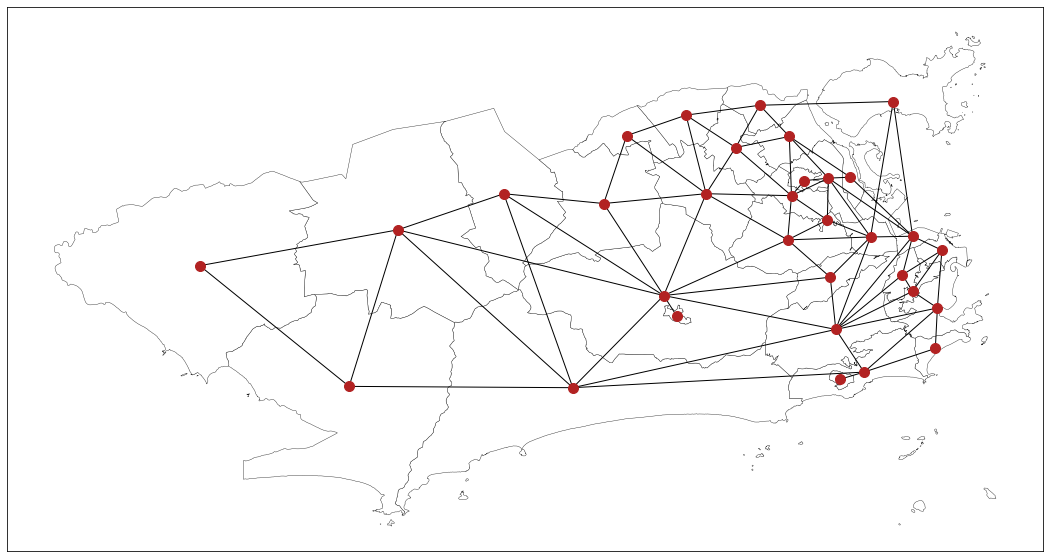

In [11]:
# Plot Graph
f, ax = plt.subplots(figsize=(20, 10))

nx.draw_networkx(neighboringG, nx.get_node_attributes(neighboringG, 'pos'), ax=ax, width=1, node_size=100, node_color='firebrick', with_labels=False)
administrative_regions.plot(ax=ax, edgecolor='#202020', color='#ffffff', linewidth=0.4, zorder=-1)

#### Generate Demand Matrix

The demand matrix for this instance is extracted from the Urban Transportation Plan for Rio de Janeiro Metropolitan Region. The selection includes all motorized trips (with exception of trucks, metros, trains and ferries), and includes only trips inside the city of Rio de Janeiro.

In [12]:
# Read CSV
demand_matrix = pd.read_csv('data/adm_region_od_matrix.csv', delimiter=';', encoding='cp1252', index_col=0).fillna(0)

# Transform to Numpy Array
demand_matrix = demand_matrix.to_numpy().astype(np.int32)

# Set diagonal to zero
np.fill_diagonal(demand_matrix, 0)

# Print
print(demand_matrix)

[[    0  2159  1201 ...   706   593   529]
 [ 2882     0  9193 ...  1577   761  4085]
 [ 1593  6573     0 ... 11162   643 10675]
 ...
 [  408  1648  7633 ...     0   754 36546]
 [  654   978   253 ...   492     0  2413]
 [  864  3215  9238 ... 29278  3412     0]]


#### Enumerate Paths

Since we are working with a small instance we are going to enumerate all possible paths from all origins and all destinations. This instance allows for multiple paths in some cases, for that we calculate the $k$ shortest paths. Given a large enough $k$ we expect for all possible paths to be calculated. This approach would be unfeasible in larger networks, however.

Since we calculated routes using all possible paths, the set of possible paths is identical to the set of routes.

In [13]:
# Generate OD Pairs List
od_pairs = generate_od_pair_list(neighboringG, demand_matrix)

In [14]:
# Generate Paths
paths, num_paths = generate_paths(neighboringG, od_pairs)

#### Generating Routes (Heuristic Approach)

Generates routes based on a heuristic route generation algorithm (HRGA) proposed by Kiliç and Gok (2014). This is a slightly modified version of their algorithm. The generated routes, however, are not optimized. Basic settings for instance 4 use 1300 routes, and a min of 5 nodes and max of 12 nodes.

In [15]:
# Initialize set of routes
initial_set = initialize_routes(neighboringG, demand_matrix, num_routes=1300, minimum_nodes=5, maximum_nodes=12, method='nodes')

Initializing Route Generation Algorithm...

=======> Generating 1300 Routes...
Solution is not complete: missing node [26]
=======> 1247  of 1300 routes generated successfully!
=======> A total of 53 routes were duplicated and removed

Route 1: [1, 18, 14, 21, 23, 29, 19, 16, 29, 22, 6, 4, 28]
Route 2: [1, 18, 14, 21, 23, 29, 22, 25, 28]
Route 3: [1, 18, 19, 13, 14, 31, 21, 23, 16]
Route 4: [1, 18, 19, 29, 22, 25, 28, 4]
Route 5: [1, 20, 14, 18, 15, 19, 32, 29, 22, 25, 28, 4, 10]
Route 6: [1, 20, 14, 18, 19, 13, 16, 23, 29]
Route 7: [1, 20, 14, 18, 19, 29, 12, 31, 21, 23, 8]
Route 8: [1, 20, 14, 18, 19, 32, 29, 22, 6, 4, 17, 30]
Route 9: [1, 20, 14, 18, 19, 32, 30, 22]
Route 10: [1, 20, 14, 18, 24, 2]
Route 11: [1, 20, 14, 21, 8, 23, 16, 29, 12]
Route 12: [1, 20, 14, 21, 8, 23, 22, 29, 19, 32, 30, 4]
Route 13: [1, 20, 14, 21, 23, 8]
Route 14: [1, 20, 14, 21, 31, 20, 18, 24]
Route 15: [1, 20, 18, 14, 21, 23, 29, 12, 22, 25, 28, 4]
Route 16: [1, 20, 18, 14, 21, 31, 12, 22, 29]
Route 17: 

In [16]:
# Eliminate Routes that are too long (More than 90km)
initial_set = [route for route in initial_set if (nx.path_weight(neighboringG, route, weight='length') <= 90000)]
print(f'Number of Routes after eliminating extremly long routes: {len(initial_set)}')

Number of Routes after eliminating extremly long routes: 1070


#### Check for Route-Path Infeasibility

In [17]:
# This takes some time
# Initialize
infeasible = []

# Iterate all OD Pairs
for od_id, od in enumerate(od_pairs):
    
    od = od.split('-')
    
    origin = int(od[0])
    destination = int(od[1])

    # Get paths for OD Pair
    od_paths = paths[f'{origin}-{destination}']

    # Iterate Paths
    for path in od_paths:

        # Possible Routes
        viable_origin_routes = [route for route in initial_set if origin in route]
        viable_destination_routes = [route for route in initial_set if destination in route]

        # Iterate over viable routes
        for vo_route in viable_origin_routes:
            for vd_route in viable_destination_routes:

                vo_edges = path_nodes_to_edges(vo_route)
                vd_edges = path_nodes_to_edges(vd_route)
                
                vo_edges_rev = path_nodes_to_edges(vo_route[::-1])
                vd_edges_rev = path_nodes_to_edges(vd_route[::-1])

                path_edges = path_nodes_to_edges(path)

                # Make a set of all edges in vo and vd
                vo_vd_edges = list(set(vo_edges) | set(vd_edges) | set(vo_edges_rev) | set(vd_edges_rev))

                # If path is subset of vo_vd edges 
                if set(path_edges) <= set(vo_vd_edges):
                    #print(f'possible path found for OD {od}')
                    #print(f'Path {path_edges} -> {vo_edges} -> {vd_edges}')
                    break

            else:
                continue
                #print(f'i havent broke inner loop for OD {od}')


            #print('I broke inner loop')
            break

        else:
            #print(f'havent broken inner nor outer loop: no route combination found for OD {od}')
            continue

        #print('I broke inner and outer loops')
        break

    else:
        print(f'OD Pair {od_id + 1} is Infeasible: There is no two route combination that allows for any of the paths to be traversed. Adding to infeasibility list')
        infeasible.append(od_id)
        continue

OD Pair 32 is Infeasible: There is no two route combination that allows for any of the paths to be traversed. Adding to infeasibility list
OD Pair 45 is Infeasible: There is no two route combination that allows for any of the paths to be traversed. Adding to infeasibility list
OD Pair 115 is Infeasible: There is no two route combination that allows for any of the paths to be traversed. Adding to infeasibility list
OD Pair 117 is Infeasible: There is no two route combination that allows for any of the paths to be traversed. Adding to infeasibility list
OD Pair 125 is Infeasible: There is no two route combination that allows for any of the paths to be traversed. Adding to infeasibility list
OD Pair 126 is Infeasible: There is no two route combination that allows for any of the paths to be traversed. Adding to infeasibility list
OD Pair 129 is Infeasible: There is no two route combination that allows for any of the paths to be traversed. Adding to infeasibility list
OD Pair 157 is Infeasi

In [18]:
# Stats
print(f'{len(infeasible)} of {len(od_pairs)} ({(len(infeasible)/len(od_pairs))*100:.2f}%) of all origin destination pairs are infeasible.')

28 of 794 (3.53%) of all origin destination pairs are infeasible.


In [19]:
# Add viable routes for infeasible OD pairs
for inf_od in infeasible:
    
    # Find shortest path for this OD
    shortest_route = paths[od_pairs[inf_od]][0]
    initial_set.append(shortest_route)

#### Generate $\Delta$ Matrix

Generate $\Delta_{er}$ matrix. This matrix tells if edge $e \in E$ is part of route $r \in R$.

In [20]:
DELTA = generate_DELTA_matrix(neighboringG, initial_set)
print(f'DELTA Matrix: \n')
print(DELTA)

DELTA Matrix: 

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### Generate $\delta$ Matrix

The $\delta_{ke}^{w}$ matrix indicates if the edge $e$ is used on path $k$ chosen from origin destination pair $w$. It allows for the coupling of routes and paths in the optimization model.

This matrix has shape $[w][k][e]$

In [21]:
# Generate Matrix
delta = generate_delta_matrix(neighboringG, od_pairs, num_paths, paths)
#print(f'delta Matrix: \n')
#print(delta)

#### Generate Outputs

In [22]:
# Set graph
sG = neighboringG
set_of_routes = initial_set

In [23]:
# Nodes
node_ids = list(sG.nodes())
node_x = [sG.nodes[node]['pos'][0] for node in sG.nodes()]
node_y = [sG.nodes[node]['pos'][1] for node in sG.nodes()]


# Data
node_data = {
    'id' : node_ids,
    'x' : node_x,
    'y' : node_y,
}

# Dataframe
nodes_df = pd.DataFrame(data=node_data)

# Print
#nodes_df

In [24]:
# Edges
edge_ids = [id + 1  for id in range(len(sG.edges()))]
edge_origins = [u for u, v in sG.edges()]
edge_destinations = [v for u, v in sG.edges()]
edge_lengths = [sG[u][v]['length'] for u, v in sG.edges()]
edge_travel_time = [sG[u][v]['length'] for u, v in sG.edges()]
edge_capacity = [10 for edge in range(len(sG.edges()))]

# Data
edge_data = {
    'id' : edge_ids,
    'origin' : edge_origins,
    'destination' : edge_destinations,
    'length' : edge_lengths,
    'travel_time' : edge_travel_time,
    'capacity' : edge_capacity
}

# Dataframe
edges_df = pd.DataFrame(data=edge_data)

# Print
#edges_df

In [25]:
# OD Matrix
od_ids = [id + 1 for id in range(len(od_pairs))]
od_origin = [int(od.split('-')[0]) for od in od_pairs]
od_destination = [int(od.split('-')[1]) for od in od_pairs]
od_demand = [demand_matrix[int(od.split('-')[0]) - 1][int(od.split('-')[1]) - 1] for od in od_pairs]
od_paths = [num_paths[od] for od in od_pairs]

# Data
od_data = {
    'id' : od_ids,
    'origin' : od_origin,
    'destination' : od_destination,
    'demand' : od_demand,
    'paths' : od_paths
}

# Dataframe
od_df = pd.DataFrame(data=od_data)
#od_df

In [26]:
# Routes
route_ids = [id + 1 for id in range(len(set_of_routes))]
route_sequences = [str(sequence) for sequence in set_of_routes]
route_length = [nx.path_weight(sG, route, weight='length') for route in set_of_routes]
route_stops = [len(route) for route in set_of_routes]

# Data
route_data = {
    'id' : route_ids,
    'sequence' : route_sequences,
    'length' : route_length,
    'num_stops' : route_stops
}

route_df = pd.DataFrame(data=route_data)
#route_df

In [27]:
k = 10

# Paths
paths_id = [id + 1 for id in range(len(paths) * k)]
paths_sequence = [str(paths[od][i]) if i < len(paths[od]) else '' for od in paths for i in range(k)]
paths_length = [nx.path_weight(sG, paths[od][i], weight='length') if i < len(paths[od]) else 0 for od in paths for i in range(k)]
paths_stops = [len(paths[od][i]) if i < len(paths[od]) else 0 for od in paths for i in range(k)]
paths_od = [od_id+1 for od_id, od in enumerate(paths) for i in range(k)]

# Data
paths_data = {
    'id' : paths_id,
    'od' : paths_od,
    'sequence' : paths_sequence,
    'length' : paths_length,
    'num_stops' : paths_stops
}

paths_df = pd.DataFrame(data=paths_data)
#paths_df

In [28]:
# DELTA Matrix
DELTA_value = [edge for route in DELTA for edge in route]
edge_ids = [id + 1 for id in range(len(sG.edges()))] * len(set_of_routes)
route_ids = [id + 1 for id in range(len(set_of_routes)) for i in range(len(sG.edges()))]

# Data
DELTA_data = {
    'route_id' : route_ids,
    'edge_id' : edge_ids,    
    'DELTA' : DELTA_value
}

# Dataframe
DELTA_df = pd.DataFrame(data=DELTA_data)
#DELTA_df

In [29]:
k = 10

# delta Matrix
delta_value = [edge for od in delta for path in od for edge in path]
od_ids = [id + 1 for id in range(len(od_pairs)) for i in range(k) for j in range(len(sG.edges()))]
path_ids = [id + 1 for id in range(k) for edge in range(len(sG.edges()))] * len(od_pairs)
edge_ids = [id + 1 for id in range(len(sG.edges()))] * k * len(od_pairs)

od_origins = [int(od_pairs[id].split('-')[0]) for id in range(len(od_pairs)) for i in range(k) for j in range(len(sG.edges()))]
od_destinations = [int(od_pairs[id].split('-')[1]) for id in range(len(od_pairs)) for i in range(k) for j in range(len(sG.edges()))]

# Data
delta_data = {
    'od' : od_ids,
    'path' : path_ids,
    'edge' : edge_ids,
    'delta' : delta_value,
    'origin' : od_origins,
    'destination' : od_destinations
}

# DataFrame
delta_df = pd.DataFrame(data=delta_data)
#delta_df

In [ ]:
# CSVs
# nodes_df.to_csv('exports/instance_04/nodes.csv', index=False, sep=',')
# edges_df.to_csv('exports/instance_04/edges.csv', index=False, sep=',')
# od_df.to_csv('exports/instance_04/od_matrix.csv', index=False, sep=',')
# DELTA_df.to_csv('exports/instance_04/big_delta.csv', index=False, sep=',')
# delta_df.to_csv('exports/instance_04/small_delta.csv', index=False, sep=',')
# route_df.to_csv('exports/instance_04/routes.csv', index=False, sep=',')
# paths_df.to_csv('exports/instance_04/paths.csv', index=False, sep=',')

#### Preprocess Y Variable

In [30]:
# This takes a while...
# Vectors
y_fix_od = []
y_fix_r  = []

# Iterate over OD pairs
for i, row in od_df.iterrows():
    
    # Iterate over routes
    for i, route in enumerate(initial_set):
        
        # If neither origin, nor destination in route, add do vector
        if (row['origin'] not in route) and (row['destination'] not in route):
            
            y_fix_od.append(row['id'])
            y_fix_r.append(i+1)
            
# Print Results
print(f'y_od_r original size: {od_df.shape[0] * len(initial_set)}')
print(f'fixed_variables: {len(y_fix_od)}')
print(f'y_od_r simplified size: {(od_df.shape[0] * len(initial_set)) - len(y_fix_od)}')

y_od_r original size: 871812
fixed_variables: 442163
y_od_r simplified size: 429649


#### Reduce Dimensionality of $\delta$ Matrix

In [33]:
# This also takes some time...
# Initialize W Vector
od_path_edge = []
start_index  = []
finish_index = []

# Counter
i = 1

# Rename edges_df
df = edges_df

# Iterate over OD pairs
for j, od in enumerate(od_pairs):
    
    if j % 100 == 0:
        print(f'iterating over od pair {j+1}/{len(od_pairs)}' )
    
    # Iterate over paths
    for k in range(10):# enumerate(paths[od]):

        # If index in range
        if k < len(paths[od]):
           
            # Convert path to edges
            edges_path = path_nodes_to_edges(paths[od][k])

            # Add Starting Index
            start_index.append(i)

            # I
            i += len(edges_path) - 1

            # Add Ending Index
            finish_index.append(i)
            
            # I
            i += 1 

            # Iterate over edges
            for edge in edges_path:

                # Find edge id
                edge_id = df[((df.origin == edge[0]) & (df.destination == edge[1])) | ((df.origin == edge[1]) & (df.destination == edge[0]))].id.values[0]

                # Add id to list
                od_path_edge.append(edge_id)            
        
        # If out of range...
        else:
            
            # Add Starting Index
            start_index.append(i)

            # Add Ending Index
            finish_index.append(i)

iterating over od pair 1/794
iterating over od pair 101/794
iterating over od pair 201/794
iterating over od pair 301/794
iterating over od pair 401/794
iterating over od pair 501/794
iterating over od pair 601/794
iterating over od pair 701/794


In [34]:
print(f'Length of vector: {len(od_path_edge)}')

Length of vector: 29023


In [35]:
k = 10

# delta Matrix
od_ids = [id + 1 for id in range(len(od_pairs)) for i in range(k)]
path_ids = [id + 1 for id in range(k)] * len(od_pairs)
path_size = [len(paths[od][i]) if i < len(paths[od]) else 0 for od in od_pairs for i in range(k)]
od_origins = [int(od_pairs[id].split('-')[0]) for id in range(len(od_pairs)) for i in range(k)]
od_destinations = [int(od_pairs[id].split('-')[1]) for id in range(len(od_pairs)) for i in range(k)]


# Data
reduced_delta_data = {
    'od' : od_ids,
    'path' : path_ids,
    'path_size' : path_size,
    'w_start' : start_index,
    'w_finish' : finish_index,
    'origin' : od_origins,
    'destination' : od_destinations
}

# DataFrame
reduced_delta_df = pd.DataFrame(data=reduced_delta_data)
reduced_delta_df

,od,path,path_size,w_start,w_finish,origin,destination
0,1,1,3,1,2,1,2
1,1,2,4,3,5,1,2
2,1,3,4,6,8,1,2
3,1,4,4,9,11,1,2
4,1,5,5,12,15,1,2
...,...,...,...,...,...,...,...
7935,794,6,5,29004,29007,32,31
7936,794,7,5,29008,29011,32,31
7937,794,8,5,29012,29015,32,31
7938,794,9,5,29016,29019,32,31


In [36]:
orig = delta_df.shape[0]
redu = len(od_path_edge)

print(f'Expected Reduction in Dimensionality: from {orig} elements to {redu} elements. A {((1 - (redu/orig)) * 100):.2f} % reduction')

Expected Reduction in Dimensionality: from 579620 elements to 29023 elements. A 94.99 % reduction


#### Reduce Dimensionality of $\Delta$ Matrix

In [37]:
# This takes some time...
# Initialize Vectors
route_list = []

edge_list = []
start_pos = []
end_pos = []

# Initialize Counter
e_start = 0

# Iterate over edges
for i, edge in enumerate(list(neighboringG.edges())):
    
    # Add 1
    #e_start += 1
    
    # Append Data
    edge_list.append(i+1)
    start_pos.append(e_start+1)
    
    # Iterate over routes
    for route in initial_set:
    
        # Transform route from nodes to edges
        route_edges = path_nodes_to_edges(route)

        # If edge in route
        if (edge in route_edges) or (edge[::-1] in route_edges):
            
            # Add 1 to counter
            e_start += 1
            
            # Find route ID
            route_id = route_df[route_df.sequence == str(route)].id.values[0]

            # Append Data
            route_list.append(route_id)
            
            
    
    # Append Finish
    end_pos.append(e_start)

In [38]:
len(route_list)

8692

### Manual Array Initialization

In [39]:
sizes = [len(sG.nodes()), len(sG.edges()), len(od_pairs), len(set_of_routes), k, len(od_path_edge), len(route_list), len(y_fix_od)] 

print(f'OD Pairs  = {len(od_pairs)}')
print(f'Routes    = {len(set_of_routes)}')
print(f'Nodes     = {len(sG.nodes())}')
print(f'Edges     = {len(sG.edges())}')
print(f'Max_Paths = {k}')

OD Pairs  = 794
Routes    = 1098
Nodes     = 32
Edges     = 73
Max_Paths = 10


In [ ]:
# return_xpress_int_txt(sizes, filename='exports/instance_04/array_sizes.txt')

**Node Data**

In [ ]:
# return_xpress_int_txt(nodes_df.id, filename='exports/instance_04/node_id.txt')
# return_xpress_str_txt(administrative_regions.adm_region, filename='exports/instance_04/node_name.txt')

**Edge Data**

In [ ]:
uv = list(edges_df.origin.values) + list(edges_df.destination.values)

In [ ]:
# return_xpress_int_txt(edges_df.id, filename='exports/instance_04/edge_id.txt')
# return_xpress_int_txt(uv, filename='exports/instance_04/edge_uv.txt')
# return_xpress_int_txt(edges_df.length, filename='exports/instance_04/edge_length.txt')
# return_xpress_int_txt(edges_df.travel_time, filename='exports/instance_04/edge_time.txt')
# return_xpress_int_txt(edges_df.capacity, filename='exports/instance_04/edge_capacity.txt')

**OD Matrix Data**

In [ ]:
# return_xpress_int_txt(od_df.origin, filename='exports/instance_04/origins.txt')
# return_xpress_int_txt(od_df.destination, filename='exports/instance_04/destinations.txt')
# return_xpress_int_txt(od_df.demand, filename='exports/instance_04/demand.txt')

**Routes**

In [ ]:
frequencies = [1 for route in set_of_routes]

In [ ]:
# return_xpress_str_txt(route_df.sequence.values, filename='exports/instance_04/route_sequence.txt')
# return_xpress_int_txt(route_df.length.values, filename='exports/instance_04/route_length.txt')
# return_xpress_int_txt(frequencies, filename='exports/instance_04/route_frequency.txt')

**Paths**

In [ ]:
# return_xpress_str_txt(paths_df.sequence.values, filename='exports/instance_04/path_sequence.txt')
# return_xpress_int_txt(paths_df.length, filename='exports/instance_04/path_length.txt')

**Y Preprocessing**

In [ ]:
# return_xpress_int_txt(y_fix_od, filename='exports/instance_04/yfix_origin_destination.txt')
# return_xpress_int_txt(y_fix_r, filename='exports/instance_04/yfix_routes.txt')

**$\delta$ Dimensionality Redux**

In [ ]:
# return_xpress_int_txt(od_path_edge, filename='exports/instance_04/small_delta.txt')
# return_xpress_int_txt(reduced_delta_df.w_start, filename='exports/instance_04/small_delta_start.txt')
# return_xpress_int_txt(reduced_delta_df.w_finish, filename='exports/instance_04/small_delta_finish.txt')

**$\Delta$ Dimensionality Redux**

In [ ]:
# return_xpress_int_txt(route_list, filename='exports/instance_04/big_delta.txt')
# return_xpress_int_txt(start_pos, filename='exports/instance_04/big_delta_start.txt')
# return_xpress_int_txt(end_pos, filename='exports/instance_04/big_delta_finish.txt')

#### Plot Results

In [40]:
def draw_route(G, route, ax, width=5, color='k'):
    """
    Draws a route on a given ax
    
    Args:
        G - graph of network
        route - route, as sequence of nodes.
        ax - axis to draw

    Returns: draws route on ax.
    """
    
    # Get position for nodes
    G_positions = nx.get_node_attributes(G, 'pos')
    
    # Create graph for route
    routeG = nx.Graph()
    
    # Create Positions
    route_positions = [G_positions[node] for node in route]
    
    # Create Edges
    route_edges = [(route[i], route[i+1]) for i in range(len(route)-1)]
    route_edges_length = [G[route[i]][route[i+1]]['length'] for i in range(len(route)-1)]
    
    # Put graph together
    for i, node in enumerate(route):
        routeG.add_node(node, pos=route_positions[i])
        
    for i in range(len(route_edges)):
        routeG.add_edge(*route_edges[i], length=route_edges_length[i])
    
    # Get route positions
    route_pos = nx.get_node_attributes(routeG, 'pos')
    
    # Plot Graph
    edges_plot = nx.draw_networkx_edges(routeG, route_pos, width=width, edge_color=color)    

In [41]:
def routes_in_edge(neighboringG, edge, selected, routes):
    
    routes_in_edge = []
    
    for route in selected:
        
        route_edges = path_nodes_to_edges(routes[route-1])
    
        if (edge in route_edges) or (edge[::-1] in route_edges):
            
            routes_in_edge.append(route)
            
    return routes_in_edge

In [49]:
def draw_edge(G, edge, routes_in_edge, routes_colors=None, ax=ax):
    
    node_pos = nx.get_node_attributes(G, 'pos')

    x1 = node_pos[edge[0]][0]
    x2 = node_pos[edge[1]][0]
        
    y1 = node_pos[edge[0]][1]
    y2 = node_pos[edge[1]][1]
 
    x = np.array([x1, x2])
    y = np.array([y1, y2])

    ax.plot(x, y, lw=len(routes_in_edge)*1.5, c='firebrick', zorder=-1)

In [43]:
# Read routes from saved file
routes_df = pd.read_csv('exports/instance_04/routes.csv')
routes = [ast.literal_eval(route) for route in routes_df.sequence]

In [53]:
# Results from Instances
selected_routes_v1 = [118, 119, 125, 133, 192, 195, 213, 236, 279, 370, 387, 389, 398, 443, 465, 525, 544, 964, 729, 755, 763, 773, 880, 923, 947, 954, 975, 1032, 1034, 1035]
selected_routes_v2 = [118, 119, 192, 233, 236, 296, 327, 351, 387, 465, 525, 559, 707, 710, 763, 836, 861, 887, 952, 1032, 1034, 1037, 1038]
selected_routes_v3 = [36, 72, 115, 119, 175, 192, 213, 232, 233, 262, 276, 294, 295, 333, 398, 408, 525, 544, 557, 715, 733, 773, 861, 947, 1031, 1034, 1035, 1040]

#### Results for Instance 4 ($\alpha = 0.5, \beta = 0.3, \gamma = 0.2$)

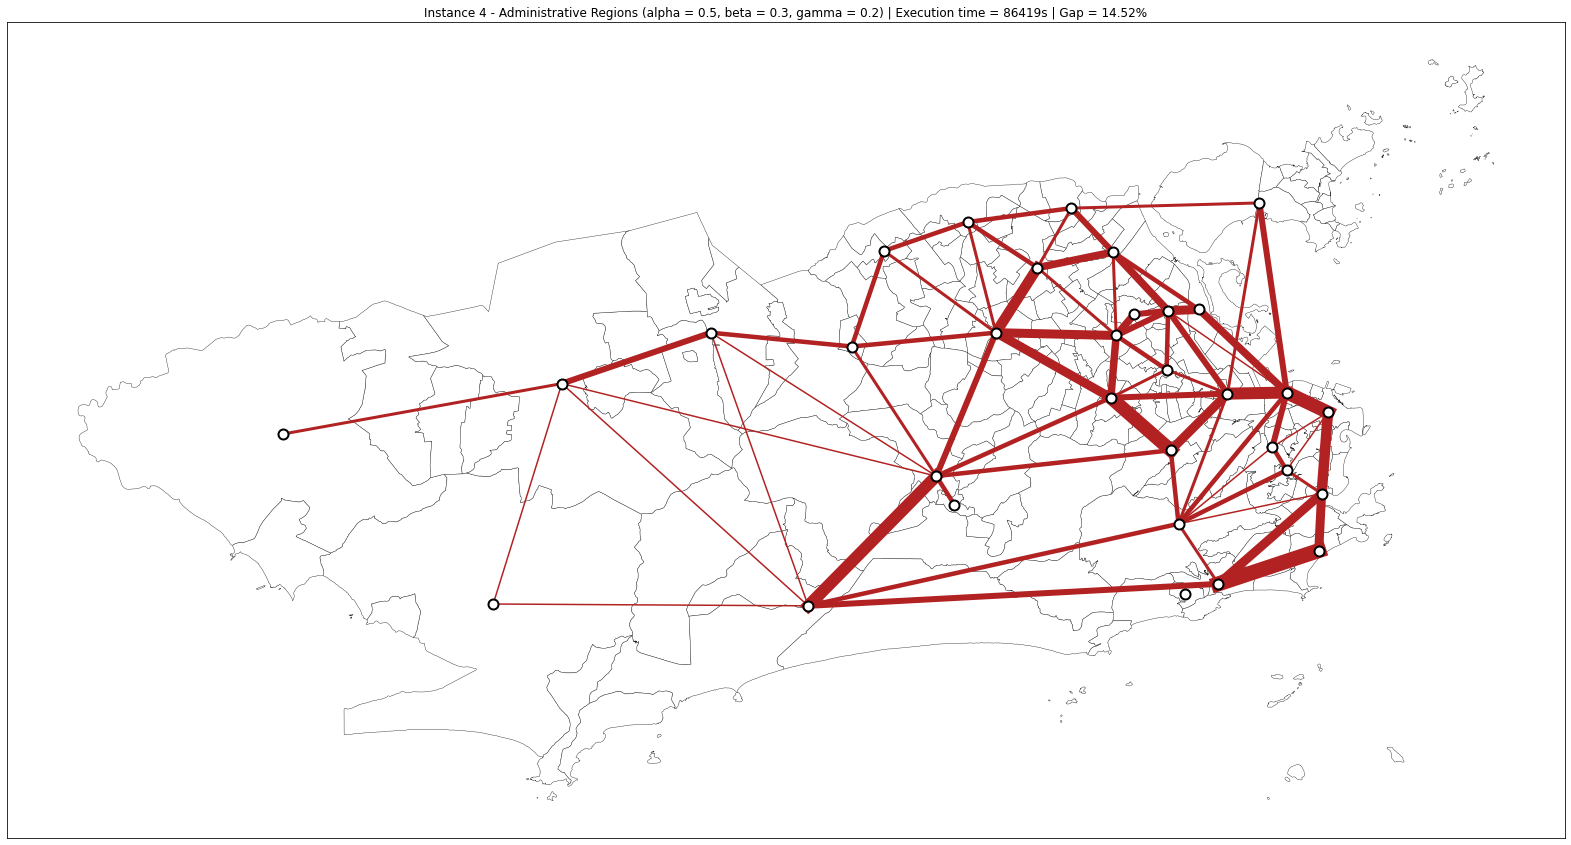

In [50]:
f, ax = plt.subplots(figsize=(30, 15))

ax.set_title(f'Instance 4 - Administrative Regions (alpha = 0.5, beta = 0.3, gamma = 0.2) | Execution time = {86419}s | Gap = {14.52}%')

neighborhoods.plot(ax=ax, edgecolor='#202020', color='#ffffff', linewidth=0.4, zorder=-1)
pos = nx.get_node_attributes(neighboringG, 'pos')
node_plot = nx.draw_networkx_nodes(neighboringG, pos, node_color='white', node_size=100)

# Change border
node_plot.set_edgecolor('k')
node_plot.set_linewidth(2)

for edge in neighboringG.edges():
    a = routes_in_edge(neighboringG, edge, selected_routes_v1, routes)
    draw_edge(neighboringG, edge, a, ax=ax)
    
plt.savefig('output/instance_4_050302.svg')
plt.savefig('output/instance_4_050302.png')

#### Results for Instance 5 ($\alpha = 0.3, \beta = 0.3, \gamma = 0.4$)

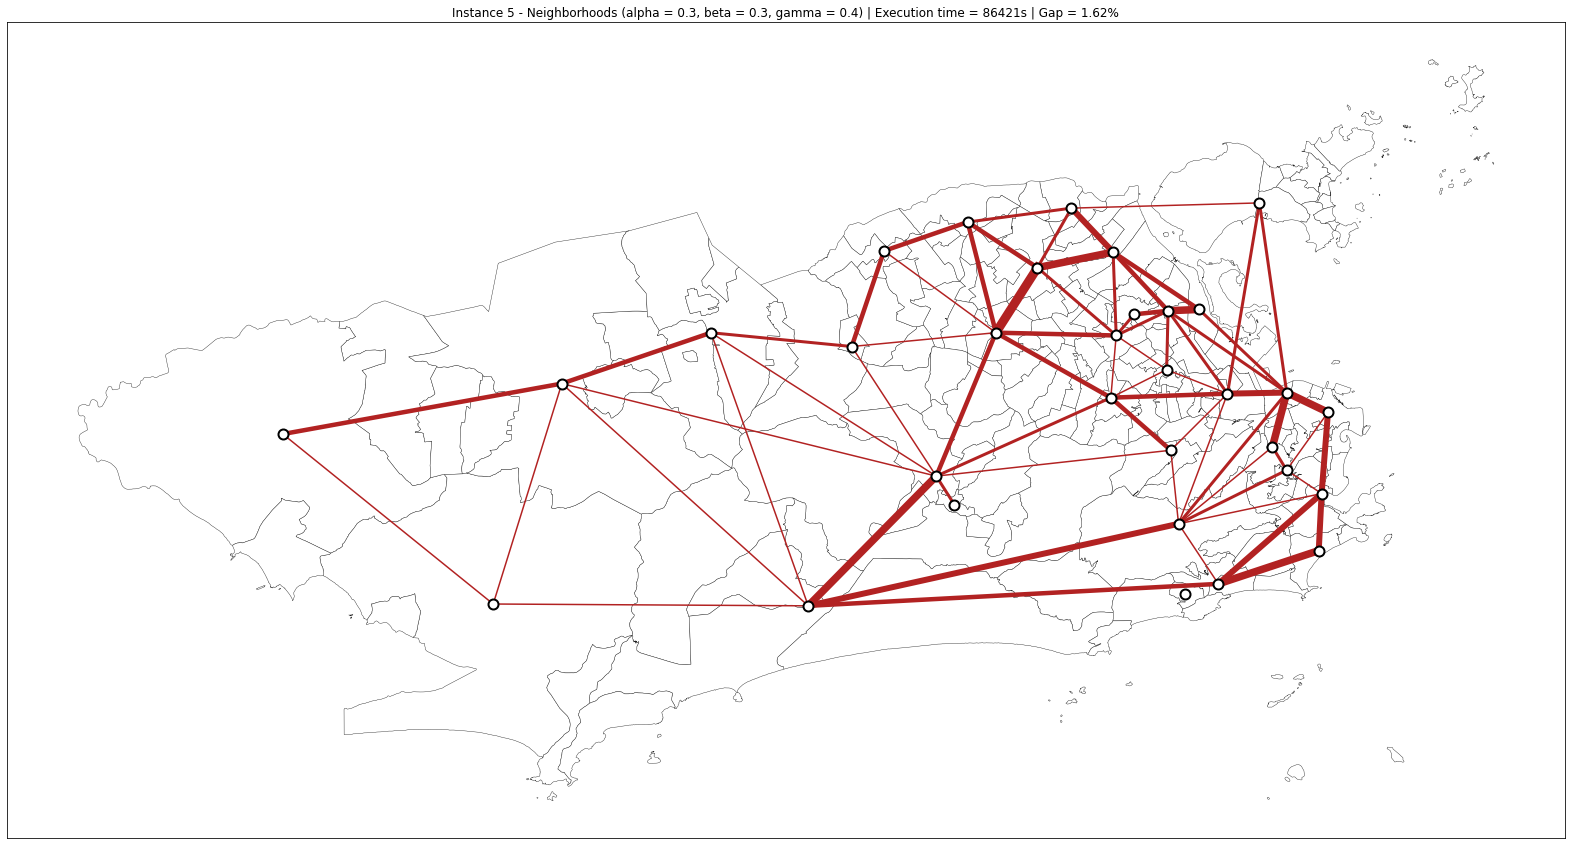

In [51]:
f, ax = plt.subplots(figsize=(30, 15))

ax.set_title(f'Instance 5 - Neighborhoods (alpha = 0.3, beta = 0.3, gamma = 0.4) | Execution time = {86421}s | Gap = {1.62}%')

neighborhoods.plot(ax=ax, edgecolor='#202020', color='#ffffff', linewidth=0.4, zorder=-1)
pos = nx.get_node_attributes(neighboringG, 'pos')
node_plot = nx.draw_networkx_nodes(neighboringG, pos, node_color='white', node_size=100)

# Change border
node_plot.set_edgecolor('k')
node_plot.set_linewidth(2)

for edge in neighboringG.edges():
    a = routes_in_edge(neighboringG, edge, selected_routes_v2, routes)
    draw_edge(neighboringG, edge, a, ax=ax)
    
plt.savefig('output/instance_4_030304.svg')
plt.savefig('output/instance_4_030304.png')

#### Results for Instance 5 ($\alpha = 0.7, \beta = 0.2, \gamma = 0.1$)

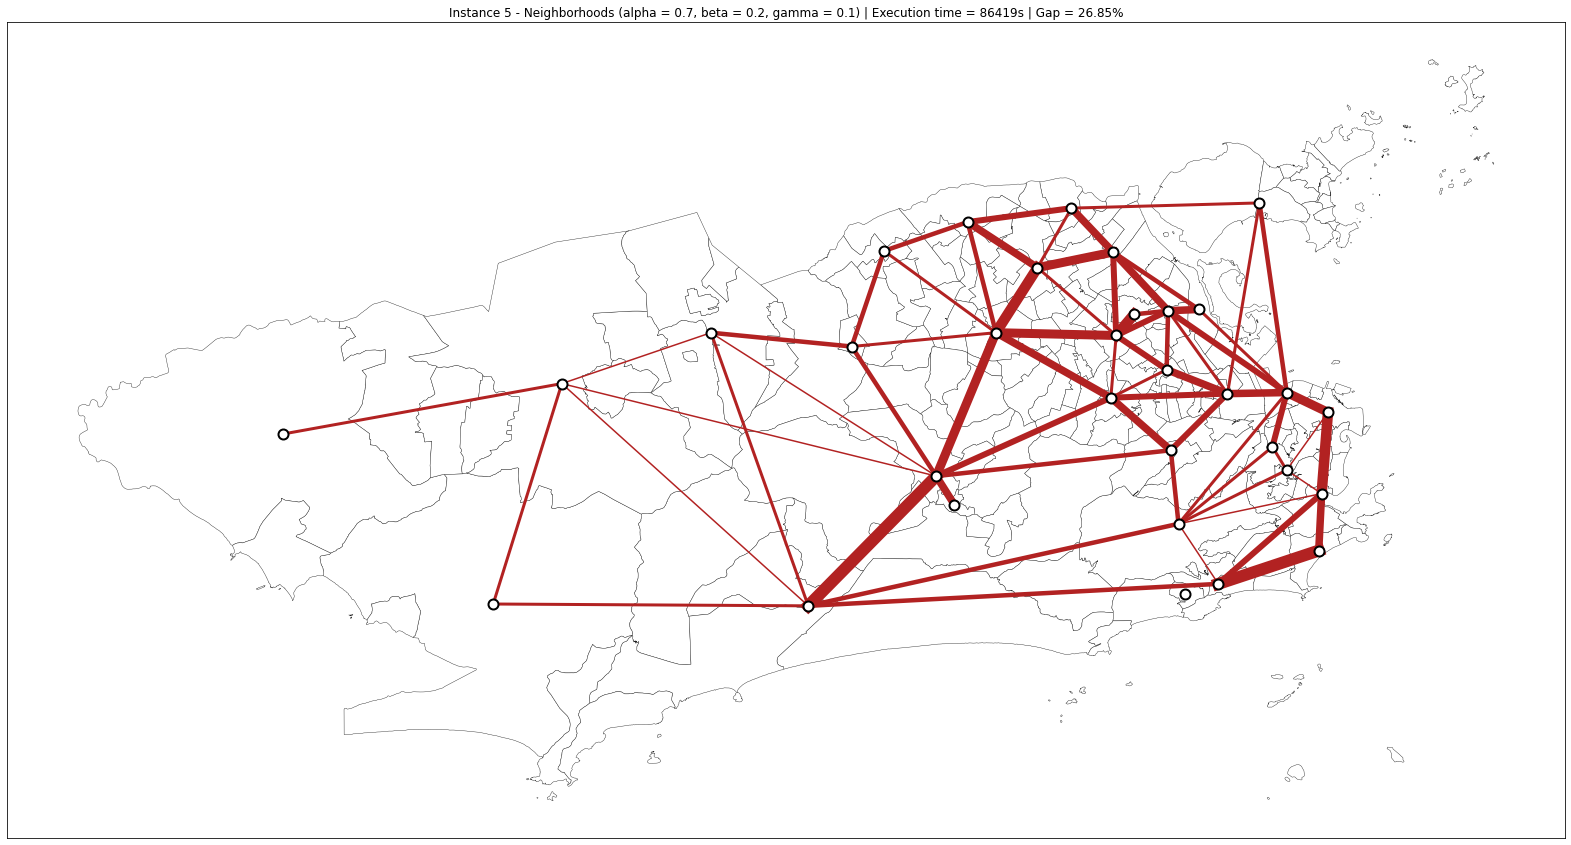

In [54]:
f, ax = plt.subplots(figsize=(30, 15))

ax.set_title(f'Instance 5 - Neighborhoods (alpha = 0.7, beta = 0.2, gamma = 0.1) | Execution time = {86419}s | Gap = {26.85}%')

neighborhoods.plot(ax=ax, edgecolor='#202020', color='#ffffff', linewidth=0.4, zorder=-1)
pos = nx.get_node_attributes(neighboringG, 'pos')
node_plot = nx.draw_networkx_nodes(neighboringG, pos, node_color='white', node_size=100)

# Change border
node_plot.set_edgecolor('k')
node_plot.set_linewidth(2)

for edge in neighboringG.edges():
    a = routes_in_edge(neighboringG, edge, selected_routes_v3, routes)
    draw_edge(neighboringG, edge, a, ax=ax)
    
plt.savefig('output/instance_4_070201.svg')
plt.savefig('output/instance_4_070201.png')